In [241]:
import numpy as np
import sympy
from collections import OrderedDict
import kwant
import kwant.continuum
import itertools as it

sympy.init_printing(print_builtin=True)

In [242]:
# For plotting
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

In [243]:
import qsymm

In [244]:
from qsymm.model import _commutative_momenta
from qsymm.groups import generate_group
from qsymm.hamiltonian_generator import hamiltonian_from_family
from qsymm.kwant_integration import kp_to_builder

In [245]:
# Spin matrices
S = qsymm.groups.spin_matrices(1/2)

In [246]:
momenta = _commutative_momenta

In [247]:
# Time reversal
TR = qsymm.PointGroupElement(sympy.eye(2), True, False, np.eye(2))

# Chiral symmetry
C = qsymm.PointGroupElement(sympy.eye(2), False, True, np.array([[1, 0], [0, -1]]))

# Atom A rotates into A, B into B.
sphi = 2*sympy.pi/3
RC3 = sympy.Matrix([[sympy.cos(sphi), -sympy.sin(sphi)],
                  [sympy.sin(sphi), sympy.cos(sphi)]])
C3 = qsymm.PointGroupElement(RC3, False, False, np.eye(2))

symmetries = [C, TR, C3]

We set the interatom distance to $1$, so the lattice vectors should have norm $\sqrt{3}$

In [248]:
norbs = OrderedDict({'A': 1, 'B': 1})  # A and B atom per unit cell, one orbital each
hopping_vectors = [('A', 'B', [1, 0])] # Hopping between neighbouring A and B atoms

In [249]:
family = qsymm.bloch_family(hopping_vectors, symmetries, norbs)

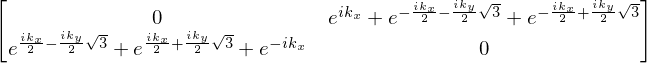

In [250]:
qsymm.display_family(family)

In [251]:
atoms, orbs = zip(*[(atom, norb) for atom, norb in norbs.items()])

In [252]:
lat_vecs = [(3/2, np.sqrt(3)/2), (3/2, -np.sqrt(3)/2)]
atom_coords = [(0, 0), (1, 0)]
coords_dict = {atom: coord for atom, coord in zip(atoms, atom_coords)}
momenta = _commutative_momenta[:len(lat_vecs[0])]

In [253]:
coords_dict

{'A': (0, 0), 'B': (1, 0)}

In [254]:
lat = kwant.lattice.general(lat_vecs,
                            atom_coords,
                            norbs=orbs)
# Store sublattices by name
sublattices = {atom: sublat for atom, sublat in zip(atoms, lat.sublattices)}
# Make a Kwant system with the Bravais lattice translational symmetry
sym = kwant.TranslationalSymmetry(*lat_vecs)
syst = kwant.Builder(sym)

In [255]:
sublattices

{'A': kwant.lattice.Monatomic([[1.5, 0.8660254037844386], [1.5, -0.8660254037844386]], [0.0, 0.0], '0', 1),
 'B': kwant.lattice.Monatomic([[1.5, 0.8660254037844386], [1.5, -0.8660254037844386]], [1.0, 0.0], '1', 1)}

In [256]:
N = 0
norbs = OrderedDict(norbs)
ranges = dict()
for a, n in norbs.items():
    ranges[a] = slice(N, N + n)
    N += n

In [257]:
# onsites
for name, sublat in sublattices.items():
    syst[sublat(0, 0)] = 0

In [267]:
for member in family:
    # Each member enters with the same coefficient.
    # Iterate over all hoppings for this member.
    for expo, hop_mat in member.items():
        # Extract the real space part of the exponential
        args = expo.args
        assert type(args[0]) == sympy.Symbol  # the e
        assert type(args[1]) in (sympy.Mul, sympy.Add)  # The argument
        # Pick out the real space part, remove the complex i
        r_vec = np.array([args[1].coeff(momentum)/sympy.I for momentum in momenta]).astype(float)
        # Iterate over combinations of atoms, set hoppings between each
        print('Term: ')
        for atom1, atom2 in it.product(atoms, atoms):
            if np.abs(hop_mat[ranges[atom2], ranges[atom1]]) > 1e-10:
                print(atom1, atom2, r_vec)
                # Adjust hopping vector to Bloch form basis
                r_lattice = r_vec - np.array(coords_dict[atom1]) + np.array(coords_dict[atom2])
                print(r_lattice)
                # Bring vector to basis of lattice vectors
                lat_basis = np.linalg.solve(np.vstack(lat_vecs).T, r_lattice)
                print('Lat bas: ', lat_basis)
                hop = (lat_basis, sublattices[atom2], sublattices[atom1]) # from atom1 to atom2
                syst[[kwant.builder.HoppingKind(*hop)]] = hop_mat[ranges[atom2], ranges[atom1]]

Term: 
B A [-0.5        0.8660254]
[-1.5        0.8660254]
Lat bas:  [ 0. -1.]
Term: 
A B [ 0.5       -0.8660254]
[ 1.5       -0.8660254]
Lat bas:  [0. 1.]
Term: 
B A [-0.5       -0.8660254]
[-1.5       -0.8660254]
Lat bas:  [-1. -0.]
Term: 
A B [0.5       0.8660254]
[1.5       0.8660254]
Lat bas:  [ 1. -0.]
Term: 
B A [1. 0.]
[0. 0.]
Lat bas:  [ 0. -0.]
Term: 
A B [-1.  0.]
[0. 0.]
Lat bas:  [ 0. -0.]


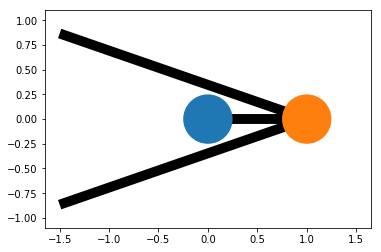

In [263]:
kwant.plot(syst);

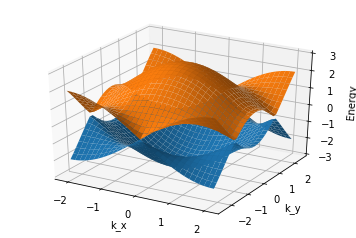

In [264]:
wrapped = kwant.wraparound.wraparound(syst).finalized()
kwant.wraparound.plot_2d_bands(wrapped);

Compare with the correct dispersion

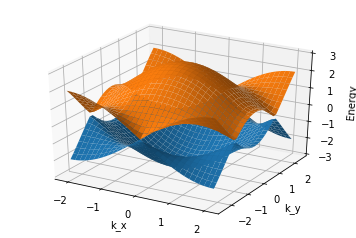

In [265]:
sym = kwant.TranslationalSymmetry(*lat_vecs)
bulk = kwant.Builder(sym)

bulk[ [sublattices['A'](0, 0), sublattices['B'](0, 0)] ] = 0
bulk[lat.neighbors()] = 1
wrapped = kwant.wraparound.wraparound(bulk).finalized()
kwant.wraparound.plot_2d_bands(wrapped);